In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV4'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dftlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

## Data transformation

In [9]:
signals = dftlib.all_I_Q_to_DFT(signals)

### Training and Test data partitioning

In [10]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [11]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [12]:
model = neural_networks.freehand_v4(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 16)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 64, 16)         64        
_________________________________________________________________
dense (Dense)                (None, 1, 64, 256)        4352  

### Train the model

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/146 [..............................] - ETA: 35:10 - loss: 2.9197

  3/146 [..............................] - ETA: 3s - loss: 2.7874   

  5/146 [>.............................] - ETA: 3s - loss: 2.6916

  7/146 [>.............................] - ETA: 3s - loss: 2.6215

  9/146 [>.............................] - ETA: 3s - loss: 2.5671

 11/146 [=>............................] - ETA: 3s - loss: 2.5234

 13/146 [=>............................] - ETA: 3s - loss: 2.4867

 15/146 [==>...........................] - ETA: 3s - loss: 2.4549

 17/146 [==>...........................] - ETA: 3s - loss: 2.4265

 20/146 [===>..........................] - ETA: 3s - loss: 2.3893

 23/146 [===>..........................] - ETA: 3s - loss: 2.3575



 25/146 [====>.........................] - ETA: 3s - loss: 2.3384

 27/146 [====>.........................] - ETA: 3s - loss: 2.3208

 30/146 [=====>........................] - ETA: 3s - loss: 2.2969



 32/146 [=====>........................] - ETA: 2s - loss: 2.2824

 34/146 [=====>........................] - ETA: 2s - loss: 2.2688



 37/146 [======>.......................] - ETA: 2s - loss: 2.2500

 39/146 [=======>......................] - ETA: 2s - loss: 2.2384

 42/146 [=======>......................] - ETA: 2s - loss: 2.2222

 45/146 [========>.....................] - ETA: 2s - loss: 2.2074

 48/146 [========>.....................] - ETA: 2s - loss: 2.1936

 50/146 [=========>....................] - ETA: 2s - loss: 2.1849

 52/146 [=========>....................] - ETA: 2s - loss: 2.1765

 54/146 [==========>...................] - ETA: 2s - loss: 2.1685

 56/146 [==========>...................] - ETA: 2s - loss: 2.1608

 58/146 [==========>...................] - ETA: 2s - loss: 2.1534

 60/146 [===========>..................] - ETA: 2s - loss: 2.1464

 62/146 [===========>..................] - ETA: 2s - loss: 2.1396



 64/146 [============>.................] - ETA: 2s - loss: 2.1331

 66/146 [============>.................] - ETA: 2s - loss: 2.1268

 68/146 [============>.................] - ETA: 2s - loss: 2.1208

 70/146 [=============>................] - ETA: 2s - loss: 2.1150



 72/146 [=============>................] - ETA: 1s - loss: 2.1094

 74/146 [==============>...............] - ETA: 1s - loss: 2.1040

 76/146 [==============>...............] - ETA: 1s - loss: 2.0988

 78/146 [===============>..............] - ETA: 1s - loss: 2.0937

 80/146 [===============>..............] - ETA: 1s - loss: 2.0888

 82/146 [===============>..............] - ETA: 1s - loss: 2.0840

 84/146 [================>.............] - ETA: 1s - loss: 2.0794

 86/146 [================>.............] - ETA: 1s - loss: 2.0749

 88/146 [=================>............] - ETA: 1s - loss: 2.0705



 90/146 [=================>............] - ETA: 1s - loss: 2.0663

 92/146 [=================>............] - ETA: 1s - loss: 2.0622

 94/146 [==================>...........] - ETA: 1s - loss: 2.0581

 96/146 [==================>...........] - ETA: 1s - loss: 2.0542

 98/146 [===================>..........] - ETA: 1s - loss: 2.0504

100/146 [===================>..........] - ETA: 1s - loss: 2.0467

102/146 [===================>..........] - ETA: 1s - loss: 2.0431

104/146 [====================>.........] - ETA: 1s - loss: 2.0396

106/146 [====================>.........] - ETA: 1s - loss: 2.0361

108/146 [=====================>........] - ETA: 1s - loss: 2.0328

110/146 [=====================>........] - ETA: 0s - loss: 2.0295

112/146 [======================>.......] - ETA: 0s - loss: 2.0263

114/146 [======================>.......] - ETA: 0s - loss: 2.0232



116/146 [======================>.......] - ETA: 0s - loss: 2.0202

118/146 [=======================>......] - ETA: 0s - loss: 2.0172

121/146 [=======================>......] - ETA: 0s - loss: 2.0129



124/146 [========================>.....] - ETA: 0s - loss: 2.0087

127/146 [=========================>....] - ETA: 0s - loss: 2.0046



130/146 [=========================>....] - ETA: 0s - loss: 2.0007

133/146 [==========================>...] - ETA: 0s - loss: 1.9968

135/146 [==========================>...] - ETA: 0s - loss: 1.9943

138/146 [===========================>..] - ETA: 0s - loss: 1.9907

141/146 [===========================>..] - ETA: 0s - loss: 1.9871

144/146 [============================>.] - ETA: 0s - loss: 1.9836

146/146 [==============================] - ETA: 0s - loss: 1.9814

146/146 [==============================] - 19s 33ms/step - loss: 1.9803 - val_loss: 5.1326


Epoch 2/100
  1/146 [..............................] - ETA: 3s - loss: 1.6544

  4/146 [..............................] - ETA: 3s - loss: 1.6961

  7/146 [>.............................] - ETA: 3s - loss: 1.7108

 10/146 [=>............................] - ETA: 3s - loss: 1.7178

 13/146 [=>............................] - ETA: 3s - loss: 1.7215

 16/146 [==>...........................] - ETA: 3s - loss: 1.7230

 19/146 [==>...........................] - ETA: 3s - loss: 1.7236

 22/146 [===>..........................] - ETA: 2s - loss: 1.7236

 25/146 [====>.........................] - ETA: 2s - loss: 1.7227

 28/146 [====>.........................] - ETA: 2s - loss: 1.7217

 31/146 [=====>........................] - ETA: 2s - loss: 1.7206

 34/146 [=====>........................] - ETA: 2s - loss: 1.7195

 37/146 [======>.......................] - ETA: 2s - loss: 1.7183

 40/146 [=======>......................] - ETA: 2s - loss: 1.7171

 43/146 [=======>......................] - ETA: 2s - loss: 1.7160

 46/146 [========>.....................] - ETA: 2s - loss: 1.7148

 49/146 [=========>....................] - ETA: 2s - loss: 1.7136

 52/146 [=========>....................] - ETA: 2s - loss: 1.7124

 55/146 [==========>...................] - ETA: 2s - loss: 1.7113

 58/146 [==========>...................] - ETA: 2s - loss: 1.7101

 61/146 [===========>..................] - ETA: 2s - loss: 1.7090

 64/146 [============>.................] - ETA: 1s - loss: 1.7079

 67/146 [============>.................] - ETA: 1s - loss: 1.7069

 70/146 [=============>................] - ETA: 1s - loss: 1.7059

 73/146 [==============>...............] - ETA: 1s - loss: 1.7049

 76/146 [==============>...............] - ETA: 1s - loss: 1.7040

 79/146 [===============>..............] - ETA: 1s - loss: 1.7031

 82/146 [===============>..............] - ETA: 1s - loss: 1.7023

 85/146 [================>.............] - ETA: 1s - loss: 1.7015



 88/146 [=================>............] - ETA: 1s - loss: 1.7007

 91/146 [=================>............] - ETA: 1s - loss: 1.7000

 94/146 [==================>...........] - ETA: 1s - loss: 1.6993

 97/146 [==================>...........] - ETA: 1s - loss: 1.6986

100/146 [===================>..........] - ETA: 1s - loss: 1.6979

102/146 [===================>..........] - ETA: 1s - loss: 1.6974

105/146 [====================>.........] - ETA: 0s - loss: 1.6967



108/146 [=====================>........] - ETA: 0s - loss: 1.6961

111/146 [=====================>........] - ETA: 0s - loss: 1.6955

114/146 [======================>.......] - ETA: 0s - loss: 1.6948

117/146 [=======================>......] - ETA: 0s - loss: 1.6942

120/146 [=======================>......] - ETA: 0s - loss: 1.6936

123/146 [========================>.....] - ETA: 0s - loss: 1.6931

126/146 [========================>.....] - ETA: 0s - loss: 1.6925

129/146 [=========================>....] - ETA: 0s - loss: 1.6920

132/146 [==========================>...] - ETA: 0s - loss: 1.6915

135/146 [==========================>...] - ETA: 0s - loss: 1.6909

138/146 [===========================>..] - ETA: 0s - loss: 1.6904

141/146 [===========================>..] - ETA: 0s - loss: 1.6899

144/146 [============================>.] - ETA: 0s - loss: 1.6894

146/146 [==============================] - 4s 25ms/step - loss: 1.6889 - val_loss: 6.3360


Epoch 3/100
  1/146 [..............................] - ETA: 3s - loss: 1.6609

  3/146 [..............................] - ETA: 4s - loss: 1.6723

  5/146 [>.............................] - ETA: 4s - loss: 1.6729



  7/146 [>.............................] - ETA: 3s - loss: 1.6755



 10/146 [=>............................] - ETA: 3s - loss: 1.6742

 13/146 [=>............................] - ETA: 3s - loss: 1.6725

 16/146 [==>...........................] - ETA: 3s - loss: 1.6713

 18/146 [==>...........................] - ETA: 3s - loss: 1.6703

 20/146 [===>..........................] - ETA: 3s - loss: 1.6694

 22/146 [===>..........................] - ETA: 3s - loss: 1.6684

 24/146 [===>..........................] - ETA: 3s - loss: 1.6674

 26/146 [====>.........................] - ETA: 3s - loss: 1.6662

 28/146 [====>.........................] - ETA: 3s - loss: 1.6652

 30/146 [=====>........................] - ETA: 3s - loss: 1.6642

 32/146 [=====>........................] - ETA: 3s - loss: 1.6633

 35/146 [======>.......................] - ETA: 2s - loss: 1.6621

 38/146 [======>.......................] - ETA: 2s - loss: 1.6609

 40/146 [=======>......................] - ETA: 2s - loss: 1.6601

 42/146 [=======>......................] - ETA: 2s - loss: 1.6593

 44/146 [========>.....................] - ETA: 2s - loss: 1.6586

 47/146 [========>.....................] - ETA: 2s - loss: 1.6574

 50/146 [=========>....................] - ETA: 2s - loss: 1.6564



 53/146 [=========>....................] - ETA: 2s - loss: 1.6554

 55/146 [==========>...................] - ETA: 2s - loss: 1.6547

 57/146 [==========>...................] - ETA: 2s - loss: 1.6540

 59/146 [===========>..................] - ETA: 2s - loss: 1.6534

 61/146 [===========>..................] - ETA: 2s - loss: 1.6528

 64/146 [============>.................] - ETA: 2s - loss: 1.6519

 67/146 [============>.................] - ETA: 2s - loss: 1.6511

 70/146 [=============>................] - ETA: 1s - loss: 1.6504

 73/146 [==============>...............] - ETA: 1s - loss: 1.6496

 76/146 [==============>...............] - ETA: 1s - loss: 1.6489

 79/146 [===============>..............] - ETA: 1s - loss: 1.6483

 82/146 [===============>..............] - ETA: 1s - loss: 1.6477

 85/146 [================>.............] - ETA: 1s - loss: 1.6471

 88/146 [=================>............] - ETA: 1s - loss: 1.6465

 91/146 [=================>............] - ETA: 1s - loss: 1.6460

 94/146 [==================>...........] - ETA: 1s - loss: 1.6455

 97/146 [==================>...........] - ETA: 1s - loss: 1.6450



 99/146 [===================>..........] - ETA: 1s - loss: 1.6446

101/146 [===================>..........] - ETA: 1s - loss: 1.6443

104/146 [====================>.........] - ETA: 1s - loss: 1.6438

107/146 [====================>.........] - ETA: 0s - loss: 1.6433

110/146 [=====================>........] - ETA: 0s - loss: 1.6428

113/146 [======================>.......] - ETA: 0s - loss: 1.6424

116/146 [======================>.......] - ETA: 0s - loss: 1.6419

119/146 [=======================>......] - ETA: 0s - loss: 1.6415

122/146 [========================>.....] - ETA: 0s - loss: 1.6410

125/146 [========================>.....] - ETA: 0s - loss: 1.6406

128/146 [=========================>....] - ETA: 0s - loss: 1.6402

131/146 [=========================>....] - ETA: 0s - loss: 1.6399

134/146 [==========================>...] - ETA: 0s - loss: 1.6395

137/146 [===========================>..] - ETA: 0s - loss: 1.6391

139/146 [===========================>..] - ETA: 0s - loss: 1.6389

141/146 [===========================>..] - ETA: 0s - loss: 1.6387

143/146 [============================>.] - ETA: 0s - loss: 1.6385

146/146 [==============================] - ETA: 0s - loss: 1.6381

146/146 [==============================] - 4s 26ms/step - loss: 1.6380 - val_loss: 4.9252


Epoch 4/100
  1/146 [..............................] - ETA: 3s - loss: 1.5943

  3/146 [..............................] - ETA: 4s - loss: 1.6009

  5/146 [>.............................] - ETA: 4s - loss: 1.6072

  7/146 [>.............................] - ETA: 3s - loss: 1.6100

 10/146 [=>............................] - ETA: 3s - loss: 1.6148

 13/146 [=>............................] - ETA: 3s - loss: 1.6171

 15/146 [==>...........................] - ETA: 3s - loss: 1.6183

 17/146 [==>...........................] - ETA: 3s - loss: 1.6189

 19/146 [==>...........................] - ETA: 3s - loss: 1.6195

 21/146 [===>..........................] - ETA: 3s - loss: 1.6200

 23/146 [===>..........................] - ETA: 3s - loss: 1.6202

 25/146 [====>.........................] - ETA: 3s - loss: 1.6203

 27/146 [====>.........................] - ETA: 3s - loss: 1.6205

 29/146 [====>.........................] - ETA: 3s - loss: 1.6207



 32/146 [=====>........................] - ETA: 3s - loss: 1.6207

 35/146 [======>.......................] - ETA: 2s - loss: 1.6205

 38/146 [======>.......................] - ETA: 2s - loss: 1.6201

 41/146 [=======>......................] - ETA: 2s - loss: 1.6197

 44/146 [========>.....................] - ETA: 2s - loss: 1.6192

 47/146 [========>.....................] - ETA: 2s - loss: 1.6187

 50/146 [=========>....................] - ETA: 2s - loss: 1.6182

 53/146 [=========>....................] - ETA: 2s - loss: 1.6176

 56/146 [==========>...................] - ETA: 2s - loss: 1.6170

 59/146 [===========>..................] - ETA: 2s - loss: 1.6165

 61/146 [===========>..................] - ETA: 2s - loss: 1.6162

 64/146 [============>.................] - ETA: 2s - loss: 1.6159

 66/146 [============>.................] - ETA: 2s - loss: 1.6156

 68/146 [============>.................] - ETA: 1s - loss: 1.6154

 71/146 [=============>................] - ETA: 1s - loss: 1.6151

 74/146 [==============>...............] - ETA: 1s - loss: 1.6148

 77/146 [==============>...............] - ETA: 1s - loss: 1.6145

 80/146 [===============>..............] - ETA: 1s - loss: 1.6142

 83/146 [================>.............] - ETA: 1s - loss: 1.6139

 86/146 [================>.............] - ETA: 1s - loss: 1.6136

 89/146 [=================>............] - ETA: 1s - loss: 1.6133

 92/146 [=================>............] - ETA: 1s - loss: 1.6130

 95/146 [==================>...........] - ETA: 1s - loss: 1.6128

 98/146 [===================>..........] - ETA: 1s - loss: 1.6126

101/146 [===================>..........] - ETA: 1s - loss: 1.6123

104/146 [====================>.........] - ETA: 1s - loss: 1.6121

107/146 [====================>.........] - ETA: 0s - loss: 1.6119

109/146 [=====================>........] - ETA: 0s - loss: 1.6117

112/146 [======================>.......] - ETA: 0s - loss: 1.6115

115/146 [======================>.......] - ETA: 0s - loss: 1.6113

118/146 [=======================>......] - ETA: 0s - loss: 1.6111

121/146 [=======================>......] - ETA: 0s - loss: 1.6109

124/146 [========================>.....] - ETA: 0s - loss: 1.6107

126/146 [========================>.....] - ETA: 0s - loss: 1.6105

129/146 [=========================>....] - ETA: 0s - loss: 1.6103

132/146 [==========================>...] - ETA: 0s - loss: 1.6102

135/146 [==========================>...] - ETA: 0s - loss: 1.6100

138/146 [===========================>..] - ETA: 0s - loss: 1.6098

141/146 [===========================>..] - ETA: 0s - loss: 1.6096

144/146 [============================>.] - ETA: 0s - loss: 1.6095

146/146 [==============================] - 4s 26ms/step - loss: 1.6093 - val_loss: 2.5040


Epoch 5/100
  1/146 [..............................] - ETA: 3s - loss: 1.6258

  4/146 [..............................] - ETA: 3s - loss: 1.6323

  7/146 [>.............................] - ETA: 3s - loss: 1.6342

 10/146 [=>............................] - ETA: 3s - loss: 1.6332

 13/146 [=>............................] - ETA: 3s - loss: 1.6315

 16/146 [==>...........................] - ETA: 3s - loss: 1.6307

 19/146 [==>...........................] - ETA: 3s - loss: 1.6293

 22/146 [===>..........................] - ETA: 3s - loss: 1.6279

 25/146 [====>.........................] - ETA: 2s - loss: 1.6266

 28/146 [====>.........................] - ETA: 2s - loss: 1.6251

 31/146 [=====>........................] - ETA: 2s - loss: 1.6238

 34/146 [=====>........................] - ETA: 2s - loss: 1.6226

 37/146 [======>.......................] - ETA: 2s - loss: 1.6213

 39/146 [=======>......................] - ETA: 2s - loss: 1.6205

 41/146 [=======>......................] - ETA: 2s - loss: 1.6197

 44/146 [========>.....................] - ETA: 2s - loss: 1.6183

 47/146 [========>.....................] - ETA: 2s - loss: 1.6171

 50/146 [=========>....................] - ETA: 2s - loss: 1.6159

 53/146 [=========>....................] - ETA: 2s - loss: 1.6148

 55/146 [==========>...................] - ETA: 2s - loss: 1.6142

 57/146 [==========>...................] - ETA: 2s - loss: 1.6136

 59/146 [===========>..................] - ETA: 2s - loss: 1.6130

 61/146 [===========>..................] - ETA: 2s - loss: 1.6125

 64/146 [============>.................] - ETA: 2s - loss: 1.6117

 67/146 [============>.................] - ETA: 1s - loss: 1.6109

 70/146 [=============>................] - ETA: 1s - loss: 1.6102

 73/146 [==============>...............] - ETA: 1s - loss: 1.6096

 76/146 [==============>...............] - ETA: 1s - loss: 1.6090

 79/146 [===============>..............] - ETA: 1s - loss: 1.6084

 82/146 [===============>..............] - ETA: 1s - loss: 1.6079

 85/146 [================>.............] - ETA: 1s - loss: 1.6074

 87/146 [================>.............] - ETA: 1s - loss: 1.6070

 90/146 [=================>............] - ETA: 1s - loss: 1.6066

 93/146 [==================>...........] - ETA: 1s - loss: 1.6061

 96/146 [==================>...........] - ETA: 1s - loss: 1.6057

 98/146 [===================>..........] - ETA: 1s - loss: 1.6054

101/146 [===================>..........] - ETA: 1s - loss: 1.6050

104/146 [====================>.........] - ETA: 1s - loss: 1.6047

107/146 [====================>.........] - ETA: 0s - loss: 1.6043

110/146 [=====================>........] - ETA: 0s - loss: 1.6040

113/146 [======================>.......] - ETA: 0s - loss: 1.6037

116/146 [======================>.......] - ETA: 0s - loss: 1.6033

119/146 [=======================>......] - ETA: 0s - loss: 1.6030

122/146 [========================>.....] - ETA: 0s - loss: 1.6027

125/146 [========================>.....] - ETA: 0s - loss: 1.6024

128/146 [=========================>....] - ETA: 0s - loss: 1.6022

131/146 [=========================>....] - ETA: 0s - loss: 1.6019

134/146 [==========================>...] - ETA: 0s - loss: 1.6016

137/146 [===========================>..] - ETA: 0s - loss: 1.6014

140/146 [===========================>..] - ETA: 0s - loss: 1.6011

142/146 [============================>.] - ETA: 0s - loss: 1.6010

144/146 [============================>.] - ETA: 0s - loss: 1.6008

146/146 [==============================] - 4s 26ms/step - loss: 1.6005 - val_loss: 1.6381


Epoch 6/100
  1/146 [..............................] - ETA: 4s - loss: 1.5885

  3/146 [..............................] - ETA: 4s - loss: 1.5801

  5/146 [>.............................] - ETA: 3s - loss: 1.5838

  8/146 [>.............................] - ETA: 3s - loss: 1.5867

 10/146 [=>............................] - ETA: 3s - loss: 1.5889

 13/146 [=>............................] - ETA: 3s - loss: 1.5910

 15/146 [==>...........................] - ETA: 3s - loss: 1.5919

 18/146 [==>...........................] - ETA: 3s - loss: 1.5936

 20/146 [===>..........................] - ETA: 3s - loss: 1.5942

 23/146 [===>..........................] - ETA: 3s - loss: 1.5947

 26/146 [====>.........................] - ETA: 3s - loss: 1.5948

 29/146 [====>.........................] - ETA: 2s - loss: 1.5949

 32/146 [=====>........................] - ETA: 2s - loss: 1.5946

 35/146 [======>.......................] - ETA: 2s - loss: 1.5945

 38/146 [======>.......................] - ETA: 2s - loss: 1.5944

 41/146 [=======>......................] - ETA: 2s - loss: 1.5940

 44/146 [========>.....................] - ETA: 2s - loss: 1.5937

 47/146 [========>.....................] - ETA: 2s - loss: 1.5932

 49/146 [=========>....................] - ETA: 2s - loss: 1.5930

 52/146 [=========>....................] - ETA: 2s - loss: 1.5926

 55/146 [==========>...................] - ETA: 2s - loss: 1.5923

 58/146 [==========>...................] - ETA: 2s - loss: 1.5920

 61/146 [===========>..................] - ETA: 2s - loss: 1.5916

 64/146 [============>.................] - ETA: 2s - loss: 1.5912

 67/146 [============>.................] - ETA: 1s - loss: 1.5909

 70/146 [=============>................] - ETA: 1s - loss: 1.5905

 73/146 [==============>...............] - ETA: 1s - loss: 1.5902

 76/146 [==============>...............] - ETA: 1s - loss: 1.5898

 79/146 [===============>..............] - ETA: 1s - loss: 1.5894

 82/146 [===============>..............] - ETA: 1s - loss: 1.5890

 85/146 [================>.............] - ETA: 1s - loss: 1.5886

 88/146 [=================>............] - ETA: 1s - loss: 1.5883

 91/146 [=================>............] - ETA: 1s - loss: 1.5880

 94/146 [==================>...........] - ETA: 1s - loss: 1.5876

 97/146 [==================>...........] - ETA: 1s - loss: 1.5873

100/146 [===================>..........] - ETA: 1s - loss: 1.5870

103/146 [====================>.........] - ETA: 1s - loss: 1.5867

106/146 [====================>.........] - ETA: 0s - loss: 1.5864



109/146 [=====================>........] - ETA: 0s - loss: 1.5861

112/146 [======================>.......] - ETA: 0s - loss: 1.5858

114/146 [======================>.......] - ETA: 0s - loss: 1.5856

116/146 [======================>.......] - ETA: 0s - loss: 1.5854

118/146 [=======================>......] - ETA: 0s - loss: 1.5853

120/146 [=======================>......] - ETA: 0s - loss: 1.5851

123/146 [========================>.....] - ETA: 0s - loss: 1.5849

126/146 [========================>.....] - ETA: 0s - loss: 1.5846

129/146 [=========================>....] - ETA: 0s - loss: 1.5844

132/146 [==========================>...] - ETA: 0s - loss: 1.5842

134/146 [==========================>...] - ETA: 0s - loss: 1.5841

136/146 [==========================>...] - ETA: 0s - loss: 1.5840

138/146 [===========================>..] - ETA: 0s - loss: 1.5838

140/146 [===========================>..] - ETA: 0s - loss: 1.5837

142/146 [============================>.] - ETA: 0s - loss: 1.5836

145/146 [============================>.] - ETA: 0s - loss: 1.5833

146/146 [==============================] - 4s 26ms/step - loss: 1.5832 - val_loss: 1.5366


Epoch 7/100
  1/146 [..............................] - ETA: 3s - loss: 1.5903

  4/146 [..............................] - ETA: 3s - loss: 1.5871

  7/146 [>.............................] - ETA: 3s - loss: 1.5840

 10/146 [=>............................] - ETA: 3s - loss: 1.5818

 13/146 [=>............................] - ETA: 3s - loss: 1.5808

 16/146 [==>...........................] - ETA: 3s - loss: 1.5808

 19/146 [==>...........................] - ETA: 3s - loss: 1.5811

 22/146 [===>..........................] - ETA: 2s - loss: 1.5813

 25/146 [====>.........................] - ETA: 2s - loss: 1.5814

 28/146 [====>.........................] - ETA: 2s - loss: 1.5816

 31/146 [=====>........................] - ETA: 2s - loss: 1.5816

 34/146 [=====>........................] - ETA: 2s - loss: 1.5816

 37/146 [======>.......................] - ETA: 2s - loss: 1.5816

 40/146 [=======>......................] - ETA: 2s - loss: 1.5815

 42/146 [=======>......................] - ETA: 2s - loss: 1.5814

 45/146 [========>.....................] - ETA: 2s - loss: 1.5811

 48/146 [========>.....................] - ETA: 2s - loss: 1.5807

 51/146 [=========>....................] - ETA: 2s - loss: 1.5803

 54/146 [==========>...................] - ETA: 2s - loss: 1.5800

 57/146 [==========>...................] - ETA: 2s - loss: 1.5797

 60/146 [===========>..................] - ETA: 2s - loss: 1.5794

 63/146 [===========>..................] - ETA: 2s - loss: 1.5790

 66/146 [============>.................] - ETA: 1s - loss: 1.5787

 69/146 [=============>................] - ETA: 1s - loss: 1.5783

 72/146 [=============>................] - ETA: 1s - loss: 1.5779

 75/146 [==============>...............] - ETA: 1s - loss: 1.5775

 78/146 [===============>..............] - ETA: 1s - loss: 1.5771

 81/146 [===============>..............] - ETA: 1s - loss: 1.5767

 84/146 [================>.............] - ETA: 1s - loss: 1.5763

 87/146 [================>.............] - ETA: 1s - loss: 1.5760

 90/146 [=================>............] - ETA: 1s - loss: 1.5757

 93/146 [==================>...........] - ETA: 1s - loss: 1.5753

 96/146 [==================>...........] - ETA: 1s - loss: 1.5751

 99/146 [===================>..........] - ETA: 1s - loss: 1.5748

102/146 [===================>..........] - ETA: 1s - loss: 1.5745

105/146 [====================>.........] - ETA: 0s - loss: 1.5743

108/146 [=====================>........] - ETA: 0s - loss: 1.5741

111/146 [=====================>........] - ETA: 0s - loss: 1.5739

114/146 [======================>.......] - ETA: 0s - loss: 1.5737

117/146 [=======================>......] - ETA: 0s - loss: 1.5735

120/146 [=======================>......] - ETA: 0s - loss: 1.5733

123/146 [========================>.....] - ETA: 0s - loss: 1.5731

126/146 [========================>.....] - ETA: 0s - loss: 1.5730

129/146 [=========================>....] - ETA: 0s - loss: 1.5728

131/146 [=========================>....] - ETA: 0s - loss: 1.5726

133/146 [==========================>...] - ETA: 0s - loss: 1.5725

135/146 [==========================>...] - ETA: 0s - loss: 1.5724

138/146 [===========================>..] - ETA: 0s - loss: 1.5722

141/146 [===========================>..] - ETA: 0s - loss: 1.5721

144/146 [============================>.] - ETA: 0s - loss: 1.5719

146/146 [==============================] - 4s 25ms/step - loss: 1.5717 - val_loss: 1.5709


Epoch 8/100
  1/146 [..............................] - ETA: 3s - loss: 1.5740

  3/146 [..............................] - ETA: 3s - loss: 1.5790

  5/146 [>.............................] - ETA: 3s - loss: 1.5857

  7/146 [>.............................] - ETA: 3s - loss: 1.5848

  9/146 [>.............................] - ETA: 3s - loss: 1.5835

 11/146 [=>............................] - ETA: 3s - loss: 1.5817

 14/146 [=>............................] - ETA: 3s - loss: 1.5793

 17/146 [==>...........................] - ETA: 3s - loss: 1.5775

 20/146 [===>..........................] - ETA: 3s - loss: 1.5767

 23/146 [===>..........................] - ETA: 3s - loss: 1.5762

 26/146 [====>.........................] - ETA: 3s - loss: 1.5756

 29/146 [====>.........................] - ETA: 2s - loss: 1.5750

 32/146 [=====>........................] - ETA: 2s - loss: 1.5743

 35/146 [======>.......................] - ETA: 2s - loss: 1.5737

 38/146 [======>.......................] - ETA: 2s - loss: 1.5731

 41/146 [=======>......................] - ETA: 2s - loss: 1.5725

 44/146 [========>.....................] - ETA: 2s - loss: 1.5720

 47/146 [========>.....................] - ETA: 2s - loss: 1.5715

 50/146 [=========>....................] - ETA: 2s - loss: 1.5710

 53/146 [=========>....................] - ETA: 2s - loss: 1.5705

 56/146 [==========>...................] - ETA: 2s - loss: 1.5700

 59/146 [===========>..................] - ETA: 2s - loss: 1.5695

 62/146 [===========>..................] - ETA: 2s - loss: 1.5690

 65/146 [============>.................] - ETA: 1s - loss: 1.5685

 68/146 [============>.................] - ETA: 1s - loss: 1.5680

 70/146 [=============>................] - ETA: 1s - loss: 1.5677

 73/146 [==============>...............] - ETA: 1s - loss: 1.5673

 76/146 [==============>...............] - ETA: 1s - loss: 1.5669

 79/146 [===============>..............] - ETA: 1s - loss: 1.5665

 82/146 [===============>..............] - ETA: 1s - loss: 1.5661

 85/146 [================>.............] - ETA: 1s - loss: 1.5658

 88/146 [=================>............] - ETA: 1s - loss: 1.5654

 91/146 [=================>............] - ETA: 1s - loss: 1.5650

 94/146 [==================>...........] - ETA: 1s - loss: 1.5647

 97/146 [==================>...........] - ETA: 1s - loss: 1.5643

100/146 [===================>..........] - ETA: 1s - loss: 1.5640

103/146 [====================>.........] - ETA: 1s - loss: 1.5637

106/146 [====================>.........] - ETA: 0s - loss: 1.5634

109/146 [=====================>........] - ETA: 0s - loss: 1.5632

112/146 [======================>.......] - ETA: 0s - loss: 1.5629

115/146 [======================>.......] - ETA: 0s - loss: 1.5627

118/146 [=======================>......] - ETA: 0s - loss: 1.5624

121/146 [=======================>......] - ETA: 0s - loss: 1.5622

124/146 [========================>.....] - ETA: 0s - loss: 1.5620

127/146 [=========================>....] - ETA: 0s - loss: 1.5618

130/146 [=========================>....] - ETA: 0s - loss: 1.5616

133/146 [==========================>...] - ETA: 0s - loss: 1.5614



135/146 [==========================>...] - ETA: 0s - loss: 1.5612

137/146 [===========================>..] - ETA: 0s - loss: 1.5611

140/146 [===========================>..] - ETA: 0s - loss: 1.5609

143/146 [============================>.] - ETA: 0s - loss: 1.5607

146/146 [==============================] - ETA: 0s - loss: 1.5605

146/146 [==============================] - 4s 25ms/step - loss: 1.5605 - val_loss: 1.5022


Epoch 9/100
  1/146 [..............................] - ETA: 3s - loss: 1.5829

  4/146 [..............................] - ETA: 3s - loss: 1.5887

  7/146 [>.............................] - ETA: 3s - loss: 1.5815

 10/146 [=>............................] - ETA: 3s - loss: 1.5755

 13/146 [=>............................] - ETA: 3s - loss: 1.5716

 16/146 [==>...........................] - ETA: 3s - loss: 1.5686

 19/146 [==>...........................] - ETA: 3s - loss: 1.5665

 22/146 [===>..........................] - ETA: 2s - loss: 1.5647

 25/146 [====>.........................] - ETA: 2s - loss: 1.5635

 28/146 [====>.........................] - ETA: 2s - loss: 1.5625

 31/146 [=====>........................] - ETA: 2s - loss: 1.5615

 34/146 [=====>........................] - ETA: 2s - loss: 1.5605

 37/146 [======>.......................] - ETA: 2s - loss: 1.5594

 40/146 [=======>......................] - ETA: 2s - loss: 1.5585

 43/146 [=======>......................] - ETA: 2s - loss: 1.5576

 45/146 [========>.....................] - ETA: 2s - loss: 1.5570

 48/146 [========>.....................] - ETA: 2s - loss: 1.5563

 51/146 [=========>....................] - ETA: 2s - loss: 1.5557

 54/146 [==========>...................] - ETA: 2s - loss: 1.5551

 57/146 [==========>...................] - ETA: 2s - loss: 1.5546

 59/146 [===========>..................] - ETA: 2s - loss: 1.5542



 61/146 [===========>..................] - ETA: 2s - loss: 1.5539

 63/146 [===========>..................] - ETA: 2s - loss: 1.5536

 66/146 [============>.................] - ETA: 1s - loss: 1.5531

 69/146 [=============>................] - ETA: 1s - loss: 1.5528

 72/146 [=============>................] - ETA: 1s - loss: 1.5524

 75/146 [==============>...............] - ETA: 1s - loss: 1.5520

 77/146 [==============>...............] - ETA: 1s - loss: 1.5518

 79/146 [===============>..............] - ETA: 1s - loss: 1.5516

 81/146 [===============>..............] - ETA: 1s - loss: 1.5514

 83/146 [================>.............] - ETA: 1s - loss: 1.5512

 85/146 [================>.............] - ETA: 1s - loss: 1.5511

 87/146 [================>.............] - ETA: 1s - loss: 1.5509

 89/146 [=================>............] - ETA: 1s - loss: 1.5507

 91/146 [=================>............] - ETA: 1s - loss: 1.5506

 93/146 [==================>...........] - ETA: 1s - loss: 1.5504

 96/146 [==================>...........] - ETA: 1s - loss: 1.5502

 99/146 [===================>..........] - ETA: 1s - loss: 1.5499

102/146 [===================>..........] - ETA: 1s - loss: 1.5497

104/146 [====================>.........] - ETA: 1s - loss: 1.5495

106/146 [====================>.........] - ETA: 1s - loss: 1.5494

109/146 [=====================>........] - ETA: 0s - loss: 1.5491



112/146 [======================>.......] - ETA: 0s - loss: 1.5489

115/146 [======================>.......] - ETA: 0s - loss: 1.5487

118/146 [=======================>......] - ETA: 0s - loss: 1.5485

121/146 [=======================>......] - ETA: 0s - loss: 1.5483

124/146 [========================>.....] - ETA: 0s - loss: 1.5481

127/146 [=========================>....] - ETA: 0s - loss: 1.5479

130/146 [=========================>....] - ETA: 0s - loss: 1.5477

133/146 [==========================>...] - ETA: 0s - loss: 1.5476

136/146 [==========================>...] - ETA: 0s - loss: 1.5474

138/146 [===========================>..] - ETA: 0s - loss: 1.5473

140/146 [===========================>..] - ETA: 0s - loss: 1.5472

142/146 [============================>.] - ETA: 0s - loss: 1.5471

144/146 [============================>.] - ETA: 0s - loss: 1.5470

146/146 [==============================] - 4s 26ms/step - loss: 1.5468 - val_loss: 1.4756


Epoch 10/100
  1/146 [..............................] - ETA: 3s - loss: 1.5709



  4/146 [..............................] - ETA: 3s - loss: 1.5639

  6/146 [>.............................] - ETA: 3s - loss: 1.5590

  8/146 [>.............................] - ETA: 3s - loss: 1.5587

 11/146 [=>............................] - ETA: 3s - loss: 1.5565

 14/146 [=>............................] - ETA: 3s - loss: 1.5550

 17/146 [==>...........................] - ETA: 3s - loss: 1.5531

 20/146 [===>..........................] - ETA: 3s - loss: 1.5514

 23/146 [===>..........................] - ETA: 2s - loss: 1.5502

 26/146 [====>.........................] - ETA: 2s - loss: 1.5490

 29/146 [====>.........................] - ETA: 2s - loss: 1.5481

 32/146 [=====>........................] - ETA: 2s - loss: 1.5474

 35/146 [======>.......................] - ETA: 2s - loss: 1.5467

 37/146 [======>.......................] - ETA: 2s - loss: 1.5463

 40/146 [=======>......................] - ETA: 2s - loss: 1.5457



 43/146 [=======>......................] - ETA: 2s - loss: 1.5451

 46/146 [========>.....................] - ETA: 2s - loss: 1.5445

 49/146 [=========>....................] - ETA: 2s - loss: 1.5441

 52/146 [=========>....................] - ETA: 2s - loss: 1.5436

 55/146 [==========>...................] - ETA: 2s - loss: 1.5431

 58/146 [==========>...................] - ETA: 2s - loss: 1.5426

 61/146 [===========>..................] - ETA: 2s - loss: 1.5421

 64/146 [============>.................] - ETA: 1s - loss: 1.5416

 66/146 [============>.................] - ETA: 1s - loss: 1.5414

 68/146 [============>.................] - ETA: 1s - loss: 1.5411

 70/146 [=============>................] - ETA: 1s - loss: 1.5409

 72/146 [=============>................] - ETA: 1s - loss: 1.5407

 74/146 [==============>...............] - ETA: 1s - loss: 1.5405

 76/146 [==============>...............] - ETA: 1s - loss: 1.5403

 78/146 [===============>..............] - ETA: 1s - loss: 1.5401

 80/146 [===============>..............] - ETA: 1s - loss: 1.5399

 82/146 [===============>..............] - ETA: 1s - loss: 1.5397

 85/146 [================>.............] - ETA: 1s - loss: 1.5395

 88/146 [=================>............] - ETA: 1s - loss: 1.5392

 91/146 [=================>............] - ETA: 1s - loss: 1.5389

 94/146 [==================>...........] - ETA: 1s - loss: 1.5387

 97/146 [==================>...........] - ETA: 1s - loss: 1.5385

100/146 [===================>..........] - ETA: 1s - loss: 1.5383

103/146 [====================>.........] - ETA: 1s - loss: 1.5382

106/146 [====================>.........] - ETA: 0s - loss: 1.5381

109/146 [=====================>........] - ETA: 0s - loss: 1.5379

112/146 [======================>.......] - ETA: 0s - loss: 1.5378

115/146 [======================>.......] - ETA: 0s - loss: 1.5376

118/146 [=======================>......] - ETA: 0s - loss: 1.5375

121/146 [=======================>......] - ETA: 0s - loss: 1.5373



123/146 [========================>.....] - ETA: 0s - loss: 1.5372



126/146 [========================>.....] - ETA: 0s - loss: 1.5371

129/146 [=========================>....] - ETA: 0s - loss: 1.5369

132/146 [==========================>...] - ETA: 0s - loss: 1.5368

135/146 [==========================>...] - ETA: 0s - loss: 1.5367

138/146 [===========================>..] - ETA: 0s - loss: 1.5365

141/146 [===========================>..] - ETA: 0s - loss: 1.5364

144/146 [============================>.] - ETA: 0s - loss: 1.5362



146/146 [==============================] - 4s 25ms/step - loss: 1.5361 - val_loss: 1.4693


Epoch 11/100
  1/146 [..............................] - ETA: 3s - loss: 1.5009

  4/146 [..............................] - ETA: 3s - loss: 1.5244

  7/146 [>.............................] - ETA: 3s - loss: 1.5332

  9/146 [>.............................] - ETA: 3s - loss: 1.5352

 11/146 [=>............................] - ETA: 3s - loss: 1.5365

 13/146 [=>............................] - ETA: 3s - loss: 1.5381

 16/146 [==>...........................] - ETA: 3s - loss: 1.5391

 19/146 [==>...........................] - ETA: 3s - loss: 1.5394

 22/146 [===>..........................] - ETA: 3s - loss: 1.5395

 25/146 [====>.........................] - ETA: 3s - loss: 1.5393

 28/146 [====>.........................] - ETA: 2s - loss: 1.5389

 31/146 [=====>........................] - ETA: 2s - loss: 1.5385

 34/146 [=====>........................] - ETA: 2s - loss: 1.5382

 36/146 [======>.......................] - ETA: 2s - loss: 1.5380



 38/146 [======>.......................] - ETA: 2s - loss: 1.5378

 40/146 [=======>......................] - ETA: 2s - loss: 1.5376

 42/146 [=======>......................] - ETA: 2s - loss: 1.5373

 44/146 [========>.....................] - ETA: 2s - loss: 1.5370

 47/146 [========>.....................] - ETA: 2s - loss: 1.5366



 50/146 [=========>....................] - ETA: 2s - loss: 1.5362

 53/146 [=========>....................] - ETA: 2s - loss: 1.5357

 56/146 [==========>...................] - ETA: 2s - loss: 1.5353

 59/146 [===========>..................] - ETA: 2s - loss: 1.5349

 62/146 [===========>..................] - ETA: 2s - loss: 1.5345

 65/146 [============>.................] - ETA: 2s - loss: 1.5341

 68/146 [============>.................] - ETA: 1s - loss: 1.5337

 71/146 [=============>................] - ETA: 1s - loss: 1.5333

 74/146 [==============>...............] - ETA: 1s - loss: 1.5330

 77/146 [==============>...............] - ETA: 1s - loss: 1.5326

 80/146 [===============>..............] - ETA: 1s - loss: 1.5323

 83/146 [================>.............] - ETA: 1s - loss: 1.5320

 86/146 [================>.............] - ETA: 1s - loss: 1.5317

 89/146 [=================>............] - ETA: 1s - loss: 1.5314

 92/146 [=================>............] - ETA: 1s - loss: 1.5312

 95/146 [==================>...........] - ETA: 1s - loss: 1.5310

 98/146 [===================>..........] - ETA: 1s - loss: 1.5307

101/146 [===================>..........] - ETA: 1s - loss: 1.5305

104/146 [====================>.........] - ETA: 1s - loss: 1.5303

107/146 [====================>.........] - ETA: 0s - loss: 1.5300

110/146 [=====================>........] - ETA: 0s - loss: 1.5299

113/146 [======================>.......] - ETA: 0s - loss: 1.5297

116/146 [======================>.......] - ETA: 0s - loss: 1.5295

119/146 [=======================>......] - ETA: 0s - loss: 1.5294

121/146 [=======================>......] - ETA: 0s - loss: 1.5293

123/146 [========================>.....] - ETA: 0s - loss: 1.5292

125/146 [========================>.....] - ETA: 0s - loss: 1.5291

128/146 [=========================>....] - ETA: 0s - loss: 1.5289

131/146 [=========================>....] - ETA: 0s - loss: 1.5288

134/146 [==========================>...] - ETA: 0s - loss: 1.5286

137/146 [===========================>..] - ETA: 0s - loss: 1.5285

139/146 [===========================>..] - ETA: 0s - loss: 1.5284

141/146 [===========================>..] - ETA: 0s - loss: 1.5283

143/146 [============================>.] - ETA: 0s - loss: 1.5282

145/146 [============================>.] - ETA: 0s - loss: 1.5281

146/146 [==============================] - 4s 26ms/step - loss: 1.5280 - val_loss: 1.4655


Epoch 12/100
  1/146 [..............................] - ETA: 3s - loss: 1.5365

  4/146 [..............................] - ETA: 3s - loss: 1.5455

  7/146 [>.............................] - ETA: 3s - loss: 1.5484

 10/146 [=>............................] - ETA: 3s - loss: 1.5465

 13/146 [=>............................] - ETA: 3s - loss: 1.5448

 16/146 [==>...........................] - ETA: 3s - loss: 1.5452

 19/146 [==>...........................] - ETA: 3s - loss: 1.5458

 22/146 [===>..........................] - ETA: 2s - loss: 1.5455

 25/146 [====>.........................] - ETA: 2s - loss: 1.5452

 28/146 [====>.........................] - ETA: 2s - loss: 1.5448

 31/146 [=====>........................] - ETA: 2s - loss: 1.5442

 34/146 [=====>........................] - ETA: 2s - loss: 1.5436

 37/146 [======>.......................] - ETA: 2s - loss: 1.5428

 40/146 [=======>......................] - ETA: 2s - loss: 1.5421

 43/146 [=======>......................] - ETA: 2s - loss: 1.5415

 46/146 [========>.....................] - ETA: 2s - loss: 1.5407

 49/146 [=========>....................] - ETA: 2s - loss: 1.5401

 52/146 [=========>....................] - ETA: 2s - loss: 1.5396

 55/146 [==========>...................] - ETA: 2s - loss: 1.5391

 58/146 [==========>...................] - ETA: 2s - loss: 1.5385

 61/146 [===========>..................] - ETA: 2s - loss: 1.5379

 64/146 [============>.................] - ETA: 1s - loss: 1.5374

 67/146 [============>.................] - ETA: 1s - loss: 1.5369

 70/146 [=============>................] - ETA: 1s - loss: 1.5364

 73/146 [==============>...............] - ETA: 1s - loss: 1.5360

 76/146 [==============>...............] - ETA: 1s - loss: 1.5355

 79/146 [===============>..............] - ETA: 1s - loss: 1.5351

 82/146 [===============>..............] - ETA: 1s - loss: 1.5348

 85/146 [================>.............] - ETA: 1s - loss: 1.5344

 88/146 [=================>............] - ETA: 1s - loss: 1.5341

 91/146 [=================>............] - ETA: 1s - loss: 1.5337

 94/146 [==================>...........] - ETA: 1s - loss: 1.5333

 97/146 [==================>...........] - ETA: 1s - loss: 1.5330

100/146 [===================>..........] - ETA: 1s - loss: 1.5327

103/146 [====================>.........] - ETA: 1s - loss: 1.5323

106/146 [====================>.........] - ETA: 0s - loss: 1.5320

109/146 [=====================>........] - ETA: 0s - loss: 1.5317

112/146 [======================>.......] - ETA: 0s - loss: 1.5314

115/146 [======================>.......] - ETA: 0s - loss: 1.5311

118/146 [=======================>......] - ETA: 0s - loss: 1.5308

121/146 [=======================>......] - ETA: 0s - loss: 1.5305

124/146 [========================>.....] - ETA: 0s - loss: 1.5303

127/146 [=========================>....] - ETA: 0s - loss: 1.5300

130/146 [=========================>....] - ETA: 0s - loss: 1.5298

133/146 [==========================>...] - ETA: 0s - loss: 1.5295

136/146 [==========================>...] - ETA: 0s - loss: 1.5293

139/146 [===========================>..] - ETA: 0s - loss: 1.5291

142/146 [============================>.] - ETA: 0s - loss: 1.5289

145/146 [============================>.] - ETA: 0s - loss: 1.5287

146/146 [==============================] - 4s 25ms/step - loss: 1.5285 - val_loss: 1.5326


Epoch 13/100
  1/146 [..............................] - ETA: 3s - loss: 1.4820

  4/146 [..............................] - ETA: 3s - loss: 1.5002

  7/146 [>.............................] - ETA: 3s - loss: 1.5108

 10/146 [=>............................] - ETA: 3s - loss: 1.5174

 13/146 [=>............................] - ETA: 3s - loss: 1.5211

 16/146 [==>...........................] - ETA: 3s - loss: 1.5230

 19/146 [==>...........................] - ETA: 3s - loss: 1.5242

 22/146 [===>..........................] - ETA: 2s - loss: 1.5251

 25/146 [====>.........................] - ETA: 2s - loss: 1.5259

 28/146 [====>.........................] - ETA: 2s - loss: 1.5263

 31/146 [=====>........................] - ETA: 2s - loss: 1.5265

 33/146 [=====>........................] - ETA: 2s - loss: 1.5266

 35/146 [======>.......................] - ETA: 2s - loss: 1.5266

 37/146 [======>.......................] - ETA: 2s - loss: 1.5266

 39/146 [=======>......................] - ETA: 2s - loss: 1.5266

 42/146 [=======>......................] - ETA: 2s - loss: 1.5265

 45/146 [========>.....................] - ETA: 2s - loss: 1.5264

 48/146 [========>.....................] - ETA: 2s - loss: 1.5262

 51/146 [=========>....................] - ETA: 2s - loss: 1.5260

 54/146 [==========>...................] - ETA: 2s - loss: 1.5259

 57/146 [==========>...................] - ETA: 2s - loss: 1.5256

 60/146 [===========>..................] - ETA: 2s - loss: 1.5254

 63/146 [===========>..................] - ETA: 2s - loss: 1.5251

 66/146 [============>.................] - ETA: 1s - loss: 1.5248

 69/146 [=============>................] - ETA: 1s - loss: 1.5246

 71/146 [=============>................] - ETA: 1s - loss: 1.5244



 73/146 [==============>...............] - ETA: 1s - loss: 1.5242

 75/146 [==============>...............] - ETA: 1s - loss: 1.5240



 77/146 [==============>...............] - ETA: 1s - loss: 1.5239

 79/146 [===============>..............] - ETA: 1s - loss: 1.5237



 81/146 [===============>..............] - ETA: 1s - loss: 1.5235



 83/146 [================>.............] - ETA: 1s - loss: 1.5233

 85/146 [================>.............] - ETA: 1s - loss: 1.5231

 87/146 [================>.............] - ETA: 1s - loss: 1.5229

 89/146 [=================>............] - ETA: 1s - loss: 1.5227

 91/146 [=================>............] - ETA: 1s - loss: 1.5225

 93/146 [==================>...........] - ETA: 1s - loss: 1.5223

 95/146 [==================>...........] - ETA: 1s - loss: 1.5221

 97/146 [==================>...........] - ETA: 1s - loss: 1.5219

100/146 [===================>..........] - ETA: 1s - loss: 1.5216

103/146 [====================>.........] - ETA: 1s - loss: 1.5214

106/146 [====================>.........] - ETA: 1s - loss: 1.5211

108/146 [=====================>........] - ETA: 0s - loss: 1.5209

110/146 [=====================>........] - ETA: 0s - loss: 1.5208

113/146 [======================>.......] - ETA: 0s - loss: 1.5205



116/146 [======================>.......] - ETA: 0s - loss: 1.5203



119/146 [=======================>......] - ETA: 0s - loss: 1.5201

122/146 [========================>.....] - ETA: 0s - loss: 1.5199

125/146 [========================>.....] - ETA: 0s - loss: 1.5196

128/146 [=========================>....] - ETA: 0s - loss: 1.5194

131/146 [=========================>....] - ETA: 0s - loss: 1.5192

134/146 [==========================>...] - ETA: 0s - loss: 1.5190

137/146 [===========================>..] - ETA: 0s - loss: 1.5188

140/146 [===========================>..] - ETA: 0s - loss: 1.5186

143/146 [============================>.] - ETA: 0s - loss: 1.5184

146/146 [==============================] - ETA: 0s - loss: 1.5182

146/146 [==============================] - 4s 26ms/step - loss: 1.5182 - val_loss: 1.4552


Epoch 14/100
  1/146 [..............................] - ETA: 3s - loss: 1.4984

  4/146 [..............................] - ETA: 3s - loss: 1.5088

  7/146 [>.............................] - ETA: 3s - loss: 1.5099

 10/146 [=>............................] - ETA: 3s - loss: 1.5109

 13/146 [=>............................] - ETA: 3s - loss: 1.5100

 16/146 [==>...........................] - ETA: 3s - loss: 1.5087

 19/146 [==>...........................] - ETA: 3s - loss: 1.5079

 22/146 [===>..........................] - ETA: 2s - loss: 1.5075

 25/146 [====>.........................] - ETA: 2s - loss: 1.5069

 28/146 [====>.........................] - ETA: 2s - loss: 1.5064

 31/146 [=====>........................] - ETA: 2s - loss: 1.5058

 34/146 [=====>........................] - ETA: 2s - loss: 1.5050

 37/146 [======>.......................] - ETA: 2s - loss: 1.5043

 40/146 [=======>......................] - ETA: 2s - loss: 1.5036

 43/146 [=======>......................] - ETA: 2s - loss: 1.5029

 46/146 [========>.....................] - ETA: 2s - loss: 1.5023

 49/146 [=========>....................] - ETA: 2s - loss: 1.5018

 52/146 [=========>....................] - ETA: 2s - loss: 1.5014

 55/146 [==========>...................] - ETA: 2s - loss: 1.5010

 58/146 [==========>...................] - ETA: 2s - loss: 1.5007

 61/146 [===========>..................] - ETA: 2s - loss: 1.5004

 64/146 [============>.................] - ETA: 1s - loss: 1.5001

 67/146 [============>.................] - ETA: 1s - loss: 1.4998

 70/146 [=============>................] - ETA: 1s - loss: 1.4994

 73/146 [==============>...............] - ETA: 1s - loss: 1.4992

 76/146 [==============>...............] - ETA: 1s - loss: 1.4990

 79/146 [===============>..............] - ETA: 1s - loss: 1.4988

 82/146 [===============>..............] - ETA: 1s - loss: 1.4986

 85/146 [================>.............] - ETA: 1s - loss: 1.4984

 88/146 [=================>............] - ETA: 1s - loss: 1.4982

 91/146 [=================>............] - ETA: 1s - loss: 1.4981

 94/146 [==================>...........] - ETA: 1s - loss: 1.4980

 97/146 [==================>...........] - ETA: 1s - loss: 1.4979

100/146 [===================>..........] - ETA: 1s - loss: 1.4978

102/146 [===================>..........] - ETA: 1s - loss: 1.4977

104/146 [====================>.........] - ETA: 1s - loss: 1.4977

106/146 [====================>.........] - ETA: 0s - loss: 1.4976

109/146 [=====================>........] - ETA: 0s - loss: 1.4975

112/146 [======================>.......] - ETA: 0s - loss: 1.4974

115/146 [======================>.......] - ETA: 0s - loss: 1.4973

118/146 [=======================>......] - ETA: 0s - loss: 1.4972

121/146 [=======================>......] - ETA: 0s - loss: 1.4971

124/146 [========================>.....] - ETA: 0s - loss: 1.4970

127/146 [=========================>....] - ETA: 0s - loss: 1.4969

130/146 [=========================>....] - ETA: 0s - loss: 1.4969

133/146 [==========================>...] - ETA: 0s - loss: 1.4968

136/146 [==========================>...] - ETA: 0s - loss: 1.4967

139/146 [===========================>..] - ETA: 0s - loss: 1.4967

142/146 [============================>.] - ETA: 0s - loss: 1.4966

145/146 [============================>.] - ETA: 0s - loss: 1.4966

146/146 [==============================] - 4s 25ms/step - loss: 1.4965 - val_loss: 1.4294


Epoch 15/100
  1/146 [..............................] - ETA: 3s - loss: 1.4493

  3/146 [..............................] - ETA: 3s - loss: 1.4705

  6/146 [>.............................] - ETA: 3s - loss: 1.4872

  9/146 [>.............................] - ETA: 3s - loss: 1.4932

 12/146 [=>............................] - ETA: 3s - loss: 1.4979

 15/146 [==>...........................] - ETA: 3s - loss: 1.5012

 18/146 [==>...........................] - ETA: 3s - loss: 1.5024

 21/146 [===>..........................] - ETA: 3s - loss: 1.5030

 23/146 [===>..........................] - ETA: 2s - loss: 1.5032

 25/146 [====>.........................] - ETA: 2s - loss: 1.5031

 27/146 [====>.........................] - ETA: 2s - loss: 1.5031

 29/146 [====>.........................] - ETA: 2s - loss: 1.5029

 31/146 [=====>........................] - ETA: 2s - loss: 1.5027

 33/146 [=====>........................] - ETA: 2s - loss: 1.5025

 35/146 [======>.......................] - ETA: 2s - loss: 1.5022

 37/146 [======>.......................] - ETA: 2s - loss: 1.5020

 40/146 [=======>......................] - ETA: 2s - loss: 1.5018

 43/146 [=======>......................] - ETA: 2s - loss: 1.5014

 46/146 [========>.....................] - ETA: 2s - loss: 1.5010

 49/146 [=========>....................] - ETA: 2s - loss: 1.5005

 52/146 [=========>....................] - ETA: 2s - loss: 1.4999

 55/146 [==========>...................] - ETA: 2s - loss: 1.4994

 57/146 [==========>...................] - ETA: 2s - loss: 1.4990

 59/146 [===========>..................] - ETA: 2s - loss: 1.4987

 61/146 [===========>..................] - ETA: 2s - loss: 1.4984

 64/146 [============>.................] - ETA: 2s - loss: 1.4980

 67/146 [============>.................] - ETA: 2s - loss: 1.4976

 70/146 [=============>................] - ETA: 1s - loss: 1.4973

 73/146 [==============>...............] - ETA: 1s - loss: 1.4970

 76/146 [==============>...............] - ETA: 1s - loss: 1.4968

 79/146 [===============>..............] - ETA: 1s - loss: 1.4965

 82/146 [===============>..............] - ETA: 1s - loss: 1.4963

 85/146 [================>.............] - ETA: 1s - loss: 1.4962

 88/146 [=================>............] - ETA: 1s - loss: 1.4960

 90/146 [=================>............] - ETA: 1s - loss: 1.4960



 92/146 [=================>............] - ETA: 1s - loss: 1.4959

 95/146 [==================>...........] - ETA: 1s - loss: 1.4958

 97/146 [==================>...........] - ETA: 1s - loss: 1.4957

 99/146 [===================>..........] - ETA: 1s - loss: 1.4956

101/146 [===================>..........] - ETA: 1s - loss: 1.4956

104/146 [====================>.........] - ETA: 1s - loss: 1.4954

107/146 [====================>.........] - ETA: 0s - loss: 1.4953

109/146 [=====================>........] - ETA: 0s - loss: 1.4952

111/146 [=====================>........] - ETA: 0s - loss: 1.4952

113/146 [======================>.......] - ETA: 0s - loss: 1.4951

116/146 [======================>.......] - ETA: 0s - loss: 1.4949

118/146 [=======================>......] - ETA: 0s - loss: 1.4949

121/146 [=======================>......] - ETA: 0s - loss: 1.4947

123/146 [========================>.....] - ETA: 0s - loss: 1.4946

125/146 [========================>.....] - ETA: 0s - loss: 1.4946

128/146 [=========================>....] - ETA: 0s - loss: 1.4944

131/146 [=========================>....] - ETA: 0s - loss: 1.4943

133/146 [==========================>...] - ETA: 0s - loss: 1.4943

135/146 [==========================>...] - ETA: 0s - loss: 1.4942

137/146 [===========================>..] - ETA: 0s - loss: 1.4941

140/146 [===========================>..] - ETA: 0s - loss: 1.4940

143/146 [============================>.] - ETA: 0s - loss: 1.4940

146/146 [==============================] - ETA: 0s - loss: 1.4939

146/146 [==============================] - 4s 26ms/step - loss: 1.4939 - val_loss: 1.4479


Epoch 16/100
  1/146 [..............................] - ETA: 3s - loss: 1.5124

  3/146 [..............................] - ETA: 3s - loss: 1.5007

  6/146 [>.............................] - ETA: 3s - loss: 1.5019

  8/146 [>.............................] - ETA: 3s - loss: 1.5054

 11/146 [=>............................] - ETA: 3s - loss: 1.5088

 14/146 [=>............................] - ETA: 3s - loss: 1.5099

 17/146 [==>...........................] - ETA: 3s - loss: 1.5097

 20/146 [===>..........................] - ETA: 3s - loss: 1.5090

 22/146 [===>..........................] - ETA: 3s - loss: 1.5085

 25/146 [====>.........................] - ETA: 2s - loss: 1.5075

 28/146 [====>.........................] - ETA: 2s - loss: 1.5066

 31/146 [=====>........................] - ETA: 2s - loss: 1.5059

 34/146 [=====>........................] - ETA: 2s - loss: 1.5052

 37/146 [======>.......................] - ETA: 2s - loss: 1.5046

 40/146 [=======>......................] - ETA: 2s - loss: 1.5038

 43/146 [=======>......................] - ETA: 2s - loss: 1.5031

 46/146 [========>.....................] - ETA: 2s - loss: 1.5024

 49/146 [=========>....................] - ETA: 2s - loss: 1.5016

 52/146 [=========>....................] - ETA: 2s - loss: 1.5008

 55/146 [==========>...................] - ETA: 2s - loss: 1.5001

 58/146 [==========>...................] - ETA: 2s - loss: 1.4994

 61/146 [===========>..................] - ETA: 2s - loss: 1.4988

 64/146 [============>.................] - ETA: 1s - loss: 1.4983

 67/146 [============>.................] - ETA: 1s - loss: 1.4978

 70/146 [=============>................] - ETA: 1s - loss: 1.4974

 73/146 [==============>...............] - ETA: 1s - loss: 1.4969

 76/146 [==============>...............] - ETA: 1s - loss: 1.4966

 79/146 [===============>..............] - ETA: 1s - loss: 1.4962

 82/146 [===============>..............] - ETA: 1s - loss: 1.4958

 85/146 [================>.............] - ETA: 1s - loss: 1.4954

 88/146 [=================>............] - ETA: 1s - loss: 1.4951

 91/146 [=================>............] - ETA: 1s - loss: 1.4948

 94/146 [==================>...........] - ETA: 1s - loss: 1.4945

 97/146 [==================>...........] - ETA: 1s - loss: 1.4942

100/146 [===================>..........] - ETA: 1s - loss: 1.4939

103/146 [====================>.........] - ETA: 1s - loss: 1.4936

106/146 [====================>.........] - ETA: 0s - loss: 1.4933

109/146 [=====================>........] - ETA: 0s - loss: 1.4931

112/146 [======================>.......] - ETA: 0s - loss: 1.4928

115/146 [======================>.......] - ETA: 0s - loss: 1.4926

118/146 [=======================>......] - ETA: 0s - loss: 1.4924

121/146 [=======================>......] - ETA: 0s - loss: 1.4922

124/146 [========================>.....] - ETA: 0s - loss: 1.4919

127/146 [=========================>....] - ETA: 0s - loss: 1.4918

130/146 [=========================>....] - ETA: 0s - loss: 1.4916

133/146 [==========================>...] - ETA: 0s - loss: 1.4914

135/146 [==========================>...] - ETA: 0s - loss: 1.4913

137/146 [===========================>..] - ETA: 0s - loss: 1.4911

139/146 [===========================>..] - ETA: 0s - loss: 1.4910

141/146 [===========================>..] - ETA: 0s - loss: 1.4909

143/146 [============================>.] - ETA: 0s - loss: 1.4908

146/146 [==============================] - ETA: 0s - loss: 1.4906

146/146 [==============================] - 4s 25ms/step - loss: 1.4906 - val_loss: 1.4299


Epoch 17/100
  1/146 [..............................] - ETA: 3s - loss: 1.4690

  4/146 [..............................] - ETA: 3s - loss: 1.4767

  7/146 [>.............................] - ETA: 3s - loss: 1.4908

 10/146 [=>............................] - ETA: 3s - loss: 1.4950

 13/146 [=>............................] - ETA: 3s - loss: 1.4966

 16/146 [==>...........................] - ETA: 3s - loss: 1.4980

 19/146 [==>...........................] - ETA: 3s - loss: 1.4989

 22/146 [===>..........................] - ETA: 2s - loss: 1.4988

 25/146 [====>.........................] - ETA: 2s - loss: 1.4984

 28/146 [====>.........................] - ETA: 2s - loss: 1.4980

 31/146 [=====>........................] - ETA: 2s - loss: 1.4974

 34/146 [=====>........................] - ETA: 2s - loss: 1.4966

 37/146 [======>.......................] - ETA: 2s - loss: 1.4956

 40/146 [=======>......................] - ETA: 2s - loss: 1.4949

 43/146 [=======>......................] - ETA: 2s - loss: 1.4942

 46/146 [========>.....................] - ETA: 2s - loss: 1.4937

 49/146 [=========>....................] - ETA: 2s - loss: 1.4932

 52/146 [=========>....................] - ETA: 2s - loss: 1.4927

 55/146 [==========>...................] - ETA: 2s - loss: 1.4922

 58/146 [==========>...................] - ETA: 2s - loss: 1.4918

 61/146 [===========>..................] - ETA: 2s - loss: 1.4914

 64/146 [============>.................] - ETA: 1s - loss: 1.4910

 67/146 [============>.................] - ETA: 1s - loss: 1.4907

 70/146 [=============>................] - ETA: 1s - loss: 1.4903

 73/146 [==============>...............] - ETA: 1s - loss: 1.4901

 76/146 [==============>...............] - ETA: 1s - loss: 1.4898

 79/146 [===============>..............] - ETA: 1s - loss: 1.4895



 82/146 [===============>..............] - ETA: 1s - loss: 1.4892

 85/146 [================>.............] - ETA: 1s - loss: 1.4890



 87/146 [================>.............] - ETA: 1s - loss: 1.4888

 89/146 [=================>............] - ETA: 1s - loss: 1.4886

 91/146 [=================>............] - ETA: 1s - loss: 1.4884

 93/146 [==================>...........] - ETA: 1s - loss: 1.4882

 95/146 [==================>...........] - ETA: 1s - loss: 1.4880

 97/146 [==================>...........] - ETA: 1s - loss: 1.4878

100/146 [===================>..........] - ETA: 1s - loss: 1.4876

103/146 [====================>.........] - ETA: 1s - loss: 1.4874

106/146 [====================>.........] - ETA: 0s - loss: 1.4872

109/146 [=====================>........] - ETA: 0s - loss: 1.4870

112/146 [======================>.......] - ETA: 0s - loss: 1.4868

115/146 [======================>.......] - ETA: 0s - loss: 1.4866

118/146 [=======================>......] - ETA: 0s - loss: 1.4864

121/146 [=======================>......] - ETA: 0s - loss: 1.4863

124/146 [========================>.....] - ETA: 0s - loss: 1.4861

126/146 [========================>.....] - ETA: 0s - loss: 1.4860

129/146 [=========================>....] - ETA: 0s - loss: 1.4859

132/146 [==========================>...] - ETA: 0s - loss: 1.4857

135/146 [==========================>...] - ETA: 0s - loss: 1.4855

138/146 [===========================>..] - ETA: 0s - loss: 1.4854

141/146 [===========================>..] - ETA: 0s - loss: 1.4852

144/146 [============================>.] - ETA: 0s - loss: 1.4851

146/146 [==============================] - 4s 25ms/step - loss: 1.4849 - val_loss: 1.4499


Epoch 18/100
  1/146 [..............................] - ETA: 3s - loss: 1.4353

  4/146 [..............................] - ETA: 3s - loss: 1.4684

  7/146 [>.............................] - ETA: 3s - loss: 1.4783

 10/146 [=>............................] - ETA: 3s - loss: 1.4823

 13/146 [=>............................] - ETA: 3s - loss: 1.4826

 16/146 [==>...........................] - ETA: 3s - loss: 1.4829

 19/146 [==>...........................] - ETA: 3s - loss: 1.4837

 22/146 [===>..........................] - ETA: 2s - loss: 1.4848

 25/146 [====>.........................] - ETA: 2s - loss: 1.4857

 28/146 [====>.........................] - ETA: 2s - loss: 1.4864

 31/146 [=====>........................] - ETA: 2s - loss: 1.4872

 34/146 [=====>........................] - ETA: 2s - loss: 1.4878

 37/146 [======>.......................] - ETA: 2s - loss: 1.4882

 40/146 [=======>......................] - ETA: 2s - loss: 1.4885

 43/146 [=======>......................] - ETA: 2s - loss: 1.4887

 46/146 [========>.....................] - ETA: 2s - loss: 1.4887

 49/146 [=========>....................] - ETA: 2s - loss: 1.4885

 52/146 [=========>....................] - ETA: 2s - loss: 1.4883

 55/146 [==========>...................] - ETA: 2s - loss: 1.4880

 58/146 [==========>...................] - ETA: 2s - loss: 1.4878

 61/146 [===========>..................] - ETA: 2s - loss: 1.4876

 64/146 [============>.................] - ETA: 1s - loss: 1.4873

 67/146 [============>.................] - ETA: 1s - loss: 1.4871

 70/146 [=============>................] - ETA: 1s - loss: 1.4868

 73/146 [==============>...............] - ETA: 1s - loss: 1.4866

 76/146 [==============>...............] - ETA: 1s - loss: 1.4863

 79/146 [===============>..............] - ETA: 1s - loss: 1.4861

 82/146 [===============>..............] - ETA: 1s - loss: 1.4858

 84/146 [================>.............] - ETA: 1s - loss: 1.4857

 86/146 [================>.............] - ETA: 1s - loss: 1.4855

 88/146 [=================>............] - ETA: 1s - loss: 1.4853

 90/146 [=================>............] - ETA: 1s - loss: 1.4851

 92/146 [=================>............] - ETA: 1s - loss: 1.4849

 94/146 [==================>...........] - ETA: 1s - loss: 1.4847

 97/146 [==================>...........] - ETA: 1s - loss: 1.4844

100/146 [===================>..........] - ETA: 1s - loss: 1.4842

103/146 [====================>.........] - ETA: 1s - loss: 1.4839

106/146 [====================>.........] - ETA: 0s - loss: 1.4836

109/146 [=====================>........] - ETA: 0s - loss: 1.4834

112/146 [======================>.......] - ETA: 0s - loss: 1.4832

115/146 [======================>.......] - ETA: 0s - loss: 1.4830

118/146 [=======================>......] - ETA: 0s - loss: 1.4828

121/146 [=======================>......] - ETA: 0s - loss: 1.4826

124/146 [========================>.....] - ETA: 0s - loss: 1.4824

127/146 [=========================>....] - ETA: 0s - loss: 1.4822

130/146 [=========================>....] - ETA: 0s - loss: 1.4820

133/146 [==========================>...] - ETA: 0s - loss: 1.4818

136/146 [==========================>...] - ETA: 0s - loss: 1.4816

139/146 [===========================>..] - ETA: 0s - loss: 1.4814

142/146 [============================>.] - ETA: 0s - loss: 1.4812

145/146 [============================>.] - ETA: 0s - loss: 1.4810

146/146 [==============================] - 4s 25ms/step - loss: 1.4808 - val_loss: 1.4795


Epoch 19/100
  1/146 [..............................] - ETA: 3s - loss: 1.4441

  4/146 [..............................] - ETA: 3s - loss: 1.4621

  7/146 [>.............................] - ETA: 3s - loss: 1.4690

 10/146 [=>............................] - ETA: 3s - loss: 1.4754

 13/146 [=>............................] - ETA: 3s - loss: 1.4793

 16/146 [==>...........................] - ETA: 3s - loss: 1.4822

 19/146 [==>...........................] - ETA: 3s - loss: 1.4840

 22/146 [===>..........................] - ETA: 3s - loss: 1.4848

 25/146 [====>.........................] - ETA: 2s - loss: 1.4850

 28/146 [====>.........................] - ETA: 2s - loss: 1.4849

 31/146 [=====>........................] - ETA: 2s - loss: 1.4849

 34/146 [=====>........................] - ETA: 2s - loss: 1.4847

 36/146 [======>.......................] - ETA: 2s - loss: 1.4845

 39/146 [=======>......................] - ETA: 2s - loss: 1.4843

 42/146 [=======>......................] - ETA: 2s - loss: 1.4843

 45/146 [========>.....................] - ETA: 2s - loss: 1.4843

 47/146 [========>.....................] - ETA: 2s - loss: 1.4842

 49/146 [=========>....................] - ETA: 2s - loss: 1.4841

 51/146 [=========>....................] - ETA: 2s - loss: 1.4840

 54/146 [==========>...................] - ETA: 2s - loss: 1.4838

 57/146 [==========>...................] - ETA: 2s - loss: 1.4836

 60/146 [===========>..................] - ETA: 2s - loss: 1.4834

 63/146 [===========>..................] - ETA: 2s - loss: 1.4832

 66/146 [============>.................] - ETA: 1s - loss: 1.4830

 69/146 [=============>................] - ETA: 1s - loss: 1.4828

 72/146 [=============>................] - ETA: 1s - loss: 1.4826

 75/146 [==============>...............] - ETA: 1s - loss: 1.4823

 78/146 [===============>..............] - ETA: 1s - loss: 1.4820

 81/146 [===============>..............] - ETA: 1s - loss: 1.4817

 84/146 [================>.............] - ETA: 1s - loss: 1.4814

 86/146 [================>.............] - ETA: 1s - loss: 1.4812

 88/146 [=================>............] - ETA: 1s - loss: 1.4810

 90/146 [=================>............] - ETA: 1s - loss: 1.4808

 93/146 [==================>...........] - ETA: 1s - loss: 1.4805

 96/146 [==================>...........] - ETA: 1s - loss: 1.4802

 99/146 [===================>..........] - ETA: 1s - loss: 1.4800

102/146 [===================>..........] - ETA: 1s - loss: 1.4798

105/146 [====================>.........] - ETA: 1s - loss: 1.4795

108/146 [=====================>........] - ETA: 0s - loss: 1.4793

111/146 [=====================>........] - ETA: 0s - loss: 1.4791

114/146 [======================>.......] - ETA: 0s - loss: 1.4789

117/146 [=======================>......] - ETA: 0s - loss: 1.4787

120/146 [=======================>......] - ETA: 0s - loss: 1.4785

123/146 [========================>.....] - ETA: 0s - loss: 1.4783

126/146 [========================>.....] - ETA: 0s - loss: 1.4781

129/146 [=========================>....] - ETA: 0s - loss: 1.4780

132/146 [==========================>...] - ETA: 0s - loss: 1.4778

135/146 [==========================>...] - ETA: 0s - loss: 1.4777

137/146 [===========================>..] - ETA: 0s - loss: 1.4776

140/146 [===========================>..] - ETA: 0s - loss: 1.4774

143/146 [============================>.] - ETA: 0s - loss: 1.4772

146/146 [==============================] - ETA: 0s - loss: 1.4771

146/146 [==============================] - 4s 25ms/step - loss: 1.4770 - val_loss: 1.4641


# Evaluate and Plot Model Performance

In [14]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 1s - loss: 1.6443

 7/54 [==>...........................] - ETA: 0s - loss: 1.2498

13/54 [======>.......................] - ETA: 0s - loss: 1.3664

19/54 [=========>....................] - ETA: 0s - loss: 1.4584

26/54 [=============>................] - ETA: 0s - loss: 1.4357



33/54 [=================>............] - ETA: 0s - loss: 1.4225

39/54 [====================>.........] - ETA: 0s - loss: 1.4152

45/54 [========================>.....] - ETA: 0s - loss: 1.4443

51/54 [===========================>..] - ETA: 0s - loss: 1.4527



54/54 [==============================] - ETA: 0s - loss: 1.4470

54/54 [==============================] - 1s 12ms/step - loss: 1.4470


1.4470325708389282


## Loss

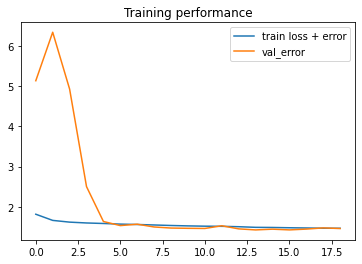

In [15]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

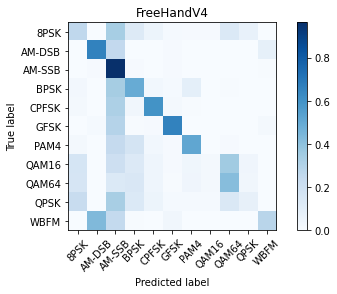

In [16]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08432392273402675


Overall Accuracy:  0.09020332717190388


Overall Accuracy:  0.09508660303994344


Overall Accuracy:  0.10154602951510892


Overall Accuracy:  0.11452312138728324


Overall Accuracy:  0.16541353383458646


Overall Accuracy:  0.29021855965603727


Overall Accuracy:  0.38699127906976744


Overall Accuracy:  0.5047923322683706


Overall Accuracy:  0.592020129403307


Overall Accuracy:  0.5951343500363108


Overall Accuracy:  0.6184637576631806


Overall Accuracy:  0.647438330170778


Overall Accuracy:  0.655223880597015


Overall Accuracy:  0.6761527377521613


Overall Accuracy:  0.6831935836675174


Overall Accuracy:  0.6667900777489819


Overall Accuracy:  0.6724332455810456


Overall Accuracy:  0.6912306558585114


Overall Accuracy:  0.6670250896057348


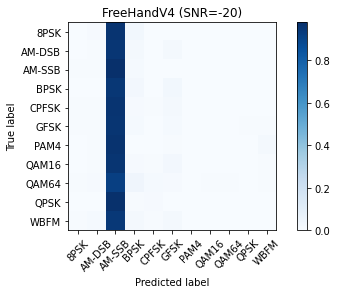

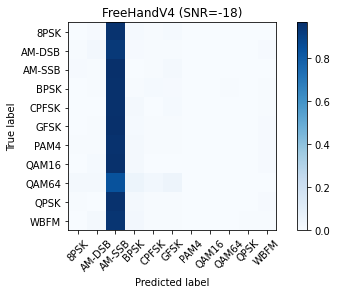

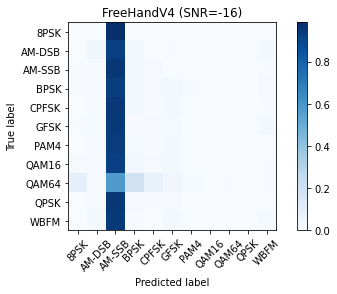

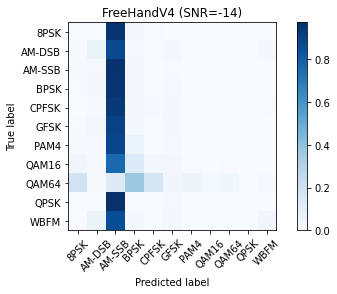

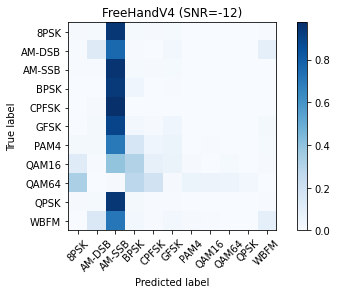

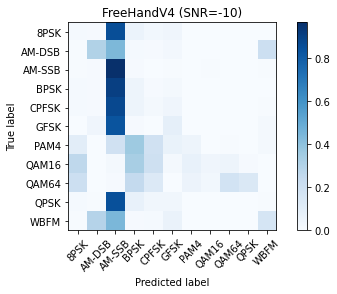

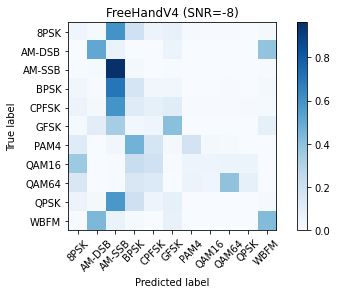

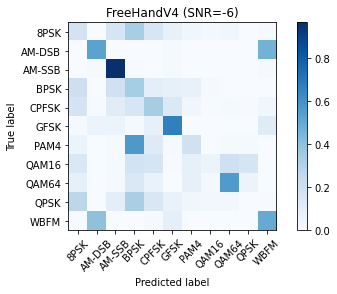

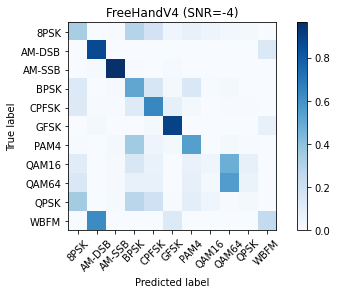

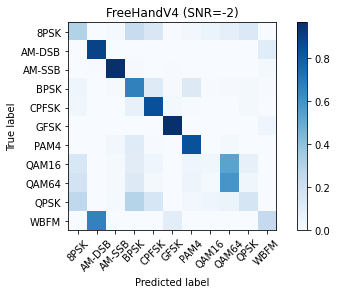

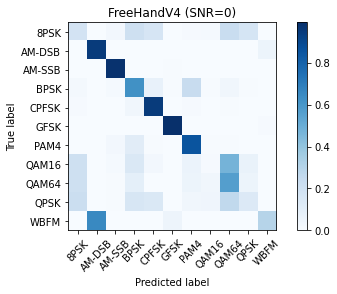

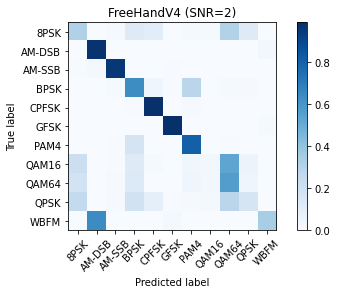

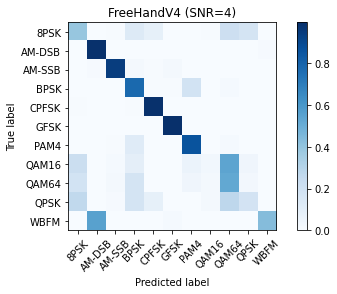

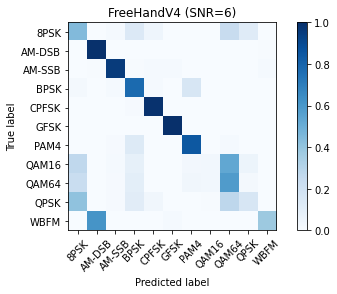

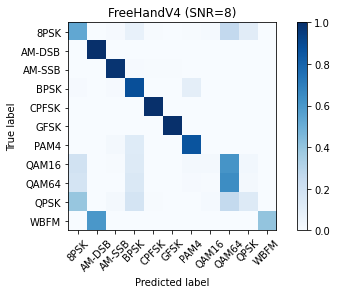

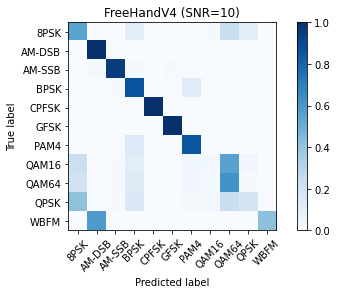

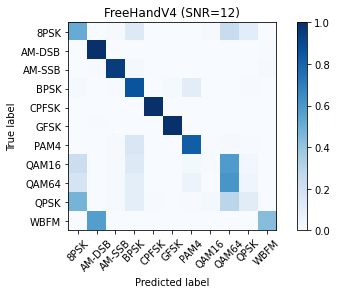

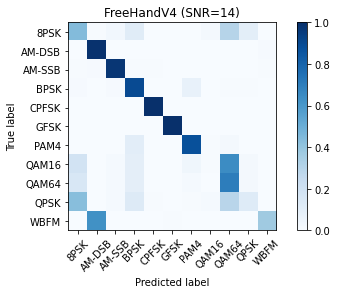

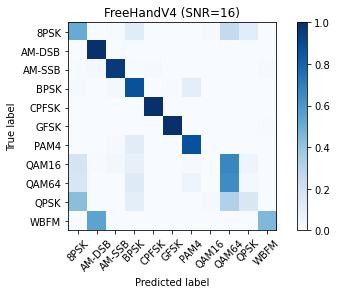

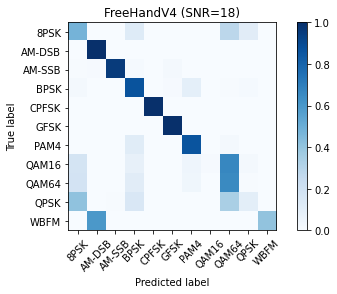

In [17]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [18]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,11,16,29,38,50,59,59,61,64,65,67,68,66,67,69,66


In [19]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

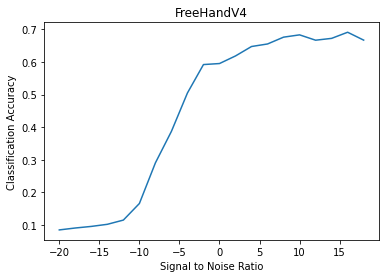

In [20]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)